In [1]:
import sys
import os

notebook_path = os.getcwd() 
project_root = os.path.dirname(notebook_path)

if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
import NN_models
import Filters
import utils
import Systems
from torch.utils.data import TensorDataset, DataLoader, random_split
from state_NN_models.StateBayesianKalmanNet import StateBayesianKalmanNet

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [5]:
h_true_nonlinear = lambda x: 0.5 * x
f_true_nonlinear = lambda x: 0.9 * x - 0.05 * x**3 

Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])

Ex0_true = torch.tensor([[1.0]])
P0_true = torch.tensor([[0.5]])

sys_true = Systems.NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

#  Nepřesná dynamika (lineární aproximace nelineární funkce f)
f_model_nonlinear = lambda x: 0.9 * x 
h_model_nonlinear = h_true_nonlinear
# Nepřesná znalost šumu (podcenění Q)
Q_model = torch.tensor([[0.01]])
R_model = torch.tensor([[0.2]])
# Nepřesný počáteční odhad (pro EKF)
Ex0_model = torch.tensor([[0.5]])
P0_model = torch.tensor([[0.5]])

# Sestavení nepřesného modelu pro filtry
# Funkce h, R jsou pro jednoduchost stejné, ale f, Q, Ex0, P0 jsou jiné
# sys_model = Systems.NonlinearSystem(f_model_nonlinear, h_model_nonlinear, Q_model, R_model, Ex0_model, P0_model)
sys_model = Systems.NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_model, P0_model)

In [6]:
TRAIN_SEQ_LEN = 10      # Krátké sekvence pro stabilní trénink (TBPTT)
VALID_SEQ_LEN = 20      # Stejná délka pro konzistentní validaci
TEST_SEQ_LEN = 200      # Dlouhé sekvence pro testování generalizace

NUM_TRAIN_TRAJ = 500   # Hodně trénovacích příkladů
NUM_VALID_TRAJ = 250    # Dostatek pro spolehlivou validaci
NUM_TEST_TRAJ = 100     # Pro robustní vyhodnocení

BATCH_SIZE = 5         # Dobrý kompromis

x_train, y_train = utils.generate_data(sys_true, num_trajectories=NUM_TRAIN_TRAJ, seq_len=TRAIN_SEQ_LEN)
x_val, y_val = utils.generate_data(sys_true, num_trajectories=NUM_VALID_TRAJ, seq_len=VALID_SEQ_LEN)
x_test, y_test = utils.generate_data(sys_true, num_trajectories=1, seq_len=TEST_SEQ_LEN)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [7]:
ekf = Filters.ExtendedKalmanFilter(sys_model)
y_test_seq = y_test.squeeze(0)
ekf_results = ekf.apply_filter(y_test_seq)
x_hat_ekf = ekf_results['x_filtered']
P_hat_ekf = ekf_results['P_filtered']

In [8]:
state_knet = StateBayesianKalmanNet(sys_model, device=device, hidden_size_multiplier=10).to(device)
utils.train_stateful_bkn(
    model=state_knet, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=device, 
    epochs=150, 
    lr=1e-4,
    J_samples=10,
    final_beta=0.01,
    beta_warmup_epochs=50
)

--- Epocha [5/150] ---
  Val Loss (MSE): 0.129258 | Current Beta: 0.0000
  Train Loss:     0.145747
    ├─ L1 (MSE):   0.124455 (váha: 1.00)
    ├─ L2 (Var L1):5.378352 (váha: 0.0000)
    └─ Regularize: 0.021291
  Predicted Var Stats: Avg=0.011835, Min=0.000000, Max=0.373867
  True Var Stats     : Avg=0.124455, Min=0.000000, Max=1.431873
  Learned p: p1=0.7498, p2=0.7577
----------------------
--- Epocha [10/150] ---
  Val Loss (MSE): 0.127569 | Current Beta: 0.0000
  Train Loss:     0.141475
    ├─ L1 (MSE):   0.123677 (váha: 1.00)
    ├─ L2 (Var L1):5.363335 (váha: 0.0000)
    └─ Regularize: 0.017799
  Predicted Var Stats: Avg=0.008687, Min=0.000000, Max=0.403259
  True Var Stats     : Avg=0.123677, Min=0.000000, Max=1.459884
  Learned p: p1=0.7416, p2=0.7549
-----------------------


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

# --- 1. Definice pomocných funkcí a metrik ---

def calculate_anees(x_true_list, x_hat_list, P_hat_list):
    """
    Vypočítá Average NEES (ANEES) ze seznamů trajektorií.
    """
    num_runs = len(x_true_list)
    if num_runs == 0:
        return 0.0
        
    total_nees = 0.0
    for i in range(num_runs):
        x_true = x_true_list[i]
        x_hat = x_hat_list[i]
        P_hat = P_hat_list[i]
        
        seq_len = x_true.shape[0]
        state_dim = x_true.shape[1]
        nees_samples_run = torch.zeros(seq_len)

        for t in range(seq_len):
            error = x_true[t] - x_hat[t]
            P_t = P_hat[t]
            
            # Pro 1D případ musíme zajistit, že P_t je matice
            if state_dim == 1:
                P_t_matrix = P_t.reshape(1, 1)
            else:
                P_t_matrix = P_t
                
            P_stable = P_t_matrix + torch.eye(state_dim) * 1e-9
            P_inv = torch.inverse(P_stable)
            
            nees_samples_run[t] = error.unsqueeze(0) @ P_inv @ error.unsqueeze(-1)
            
        total_nees += nees_samples_run.mean().item()
        
    return total_nees / num_runs

# --- 2. Příprava a generování dat ---

# Předpoklady (musí být definováno v předchozích buňkách)
# state_knet = ... (vaše instance `StateBayesianKalmanNet`)
# sys_true = ...
# sys_model = ...
# device = ...
# Filters.ExtendedKalmanFilter = ...

TEST_SEQ_LEN = 200
NUM_TEST_TRAJ = 10
J_SAMPLES_TEST = 20 # Počet MC vzorků pro inferenci

print(f"Generuji {NUM_TEST_TRAJ} testovacích trajektorií...")
x_test, y_test = utils.generate_data(sys_true, num_trajectories=NUM_TEST_TRAJ, seq_len=TEST_SEQ_LEN)

# --- 3. Vyhodnocovací smyčka ---

state_knet.eval()

# Seznamy pro sběr výsledků ze všech trajektorií
all_x_true_cpu = []
all_x_hat_knet_cpu = []
all_P_hat_knet_cpu = []
all_x_hat_ekf_cpu = []
all_P_hat_ekf_cpu = []

print(f"Vyhodnocuji na {NUM_TEST_TRAJ} testovacích trajektoriích...")

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        y_test_seq_gpu = y_test[i].to(device)
        x_true_seq_cpu = x_test[i].cpu()
        all_x_true_cpu.append(x_true_seq_cpu)
        
        # --- Vyhodnocení StateBayesianKalmanNet ---
        state_knet.reset(batch_size=1, num_samples=J_SAMPLES_TEST)
        knet_predictions = []
        knet_covariances = []
        
        for t in range(TEST_SEQ_LEN):
            y_t = y_test_seq_gpu[t, :].unsqueeze(0)
            # Získáme všechny 3 výstupy, ale regularizaci nepotřebujeme
            x_filtered_t, P_filtered_t, _ = state_knet.step(y_t, num_samples=J_SAMPLES_TEST)
            knet_predictions.append(x_filtered_t.squeeze(0))
            knet_covariances.append(P_filtered_t.squeeze(0))
            
        x_hat_knet = torch.stack(knet_predictions, dim=0).cpu()
        P_hat_knet = torch.stack(knet_covariances, dim=0).cpu()
        
        all_x_hat_knet_cpu.append(x_hat_knet)
        all_P_hat_knet_cpu.append(P_hat_knet)
        
        # --- Vyhodnocení ExtendedKalmanFilter ---
        ekf_instance = Filters.ExtendedKalmanFilter(sys_model)
        y_test_seq_ekf = y_test[i].to(ekf_instance.device)
        ekf_results = ekf_instance.apply_filter(y_test_seq_ekf)
        
        x_hat_ekf_seq = ekf_results['x_filtered'].cpu()
        P_hat_ekf_seq = ekf_results['P_filtered'].cpu()

        all_x_hat_ekf_cpu.append(x_hat_ekf_seq)
        all_P_hat_ekf_cpu.append(P_hat_ekf_seq)
        
        if (i + 1) % 10 == 0:
            print(f"Dokončeno {i + 1}/{NUM_TEST_TRAJ} běhů...")

# --- 4. Finální výpočet průměrných metrik ---

# Spojíme všechny trajektorie dohromady pro výpočet celkového MSE
x_true_all = torch.cat(all_x_true_cpu)
x_hat_knet_all = torch.cat(all_x_hat_knet_cpu)
x_hat_ekf_all = torch.cat(all_x_hat_ekf_cpu)

avg_mse_knet = F.mse_loss(x_hat_knet_all, x_true_all).item()
avg_mse_ekf = F.mse_loss(x_hat_ekf_all, x_true_all).item()

# Vypočítáme ANEES ze seznamů
anees_knet = calculate_anees(all_x_true_cpu, all_x_hat_knet_cpu, all_P_hat_knet_cpu)
anees_ekf = calculate_anees(all_x_true_cpu, all_x_hat_ekf_cpu, all_P_hat_ekf_cpu)


# --- 5. Finální výpis ---
state_dim_for_nees = x_true_seq_cpu.shape[1]

print("\n" + "="*50)
print(f"FINÁLNÍ VÝSLEDKY (průměr přes {NUM_TEST_TRAJ} běhů)")
print("="*50)

print("\n--- Průměrná MSE (přesnost) ---")
print(f"EKF:              {avg_mse_ekf:.4f}")
print(f"Bayesian KNet:    {avg_mse_knet:.4f}")

print("\n--- Průměrný ANEES (kredibilita/kalibrace) ---")
print(f"Očekávaná hodnota: {state_dim_for_nees:.4f}")
print("---------------------------------------")
print(f"EKF:              {anees_ekf:.4f}")
print(f"Bayesian KNet:    {anees_knet:.4f}")
print("="*50)

Generuji 10 testovacích trajektorií...
Vyhodnocuji na 10 testovacích trajektoriích...


KeyboardInterrupt: 

Připravuji data pro online simulaci...
Zahajuji simulaci online filtrace...
Online simulace dokončena.

--- Výsledky online simulace ---
  Celková MSE: 0.0829
  Průměrný NEES: 876.3679
  Průměrný čas na jeden krok filtrace: 22.8071 ms


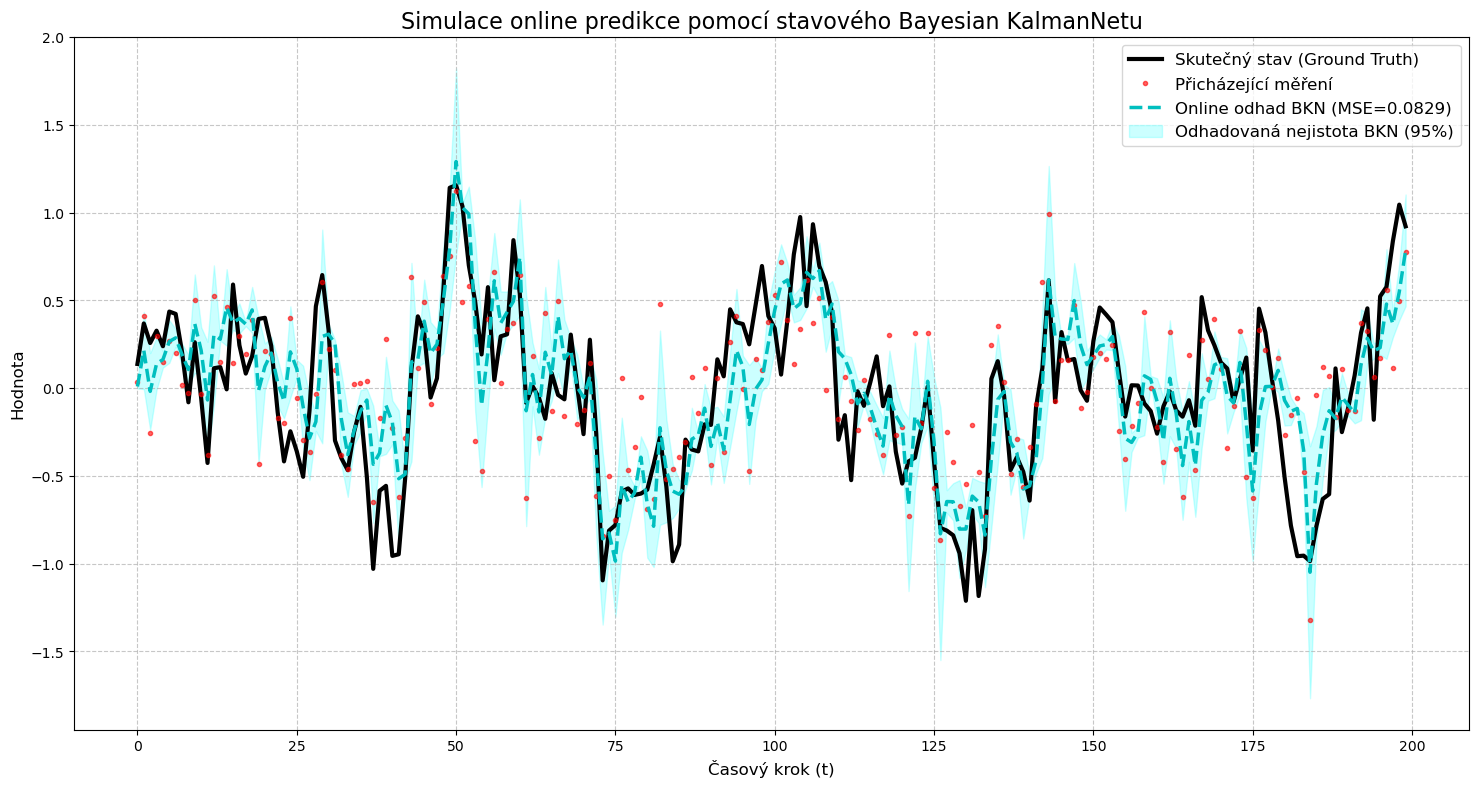

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import numpy as np

# --- 1. Definice pomocných funkcí a metrik ---

def calculate_nees(x_true, x_hat, P_hat):
    """
    Vypočítá Normalized Estimation Error Squared (NEES) pro jednu trajektorii.
    Funguje pro 1D i N-D stav.
    
    Args:
        x_true (torch.Tensor): Ground truth stavy. Tvar [seq_len, state_dim].
        x_hat (torch.Tensor): Odhadnuté stavy. Tvar [seq_len, state_dim].
        P_hat (torch.Tensor): Odhadnuté kovarianční matice. Tvar [seq_len, state_dim, state_dim].
    """
    seq_len = x_true.shape[0]
    state_dim = x_true.shape[1]
    nees_samples = torch.zeros(seq_len)

    for t in range(seq_len):
        error = x_true[t] - x_hat[t] # Tvar: [state_dim]
        P_t = P_hat[t] # Tvar: [state_dim, state_dim]
            
        # Přidání malé hodnoty na diagonálu pro numerickou stabilitu inverze
        P_stable = P_t + torch.eye(state_dim) * 1e-9
        P_inv = torch.inverse(P_stable)
        
        # Výpočet NEES: e^T * P^-1 * e
        nees_samples[t] = error.unsqueeze(0) @ P_inv @ error.unsqueeze(-1)
        
    avg_nees = nees_samples.mean().item()
    return avg_nees

# --- 2. Příprava ---

# Předpoklady (musí být definováno v předchozích buňkách)
# state_knet = ... (vaše instance `StateBayesianKalmanNet`)
# sys_true = ...
# device = ...
TEST_SEQ_LEN = 200
J_SAMPLES_TEST = 20 # Počet MC vzorků pro inferenci

print("Připravuji data pro online simulaci...")
x_online_test, y_online_test = utils.generate_data(sys_true, num_trajectories=1, seq_len=TEST_SEQ_LEN)

y_online_seq = y_online_test.squeeze(0).to(device)
x_true_seq_cpu = x_online_test.squeeze(0).cpu()

# --- 3. Simulace online filtrace ---

print("Zahajuji simulaci online filtrace...")

state_knet.eval()

# DŮLEŽITÉ: Resetujeme vnitřní stav filtru se správným počtem `num_samples`
state_knet.reset(batch_size=1, num_samples=J_SAMPLES_TEST)

# Seznamy pro sběr online odhadů
online_predictions = []
online_covariances = []
step_times = []

with torch.no_grad():
    for t in range(TEST_SEQ_LEN):
        
        start_time = time.time()
        
        y_t = y_online_seq[t, :].unsqueeze(0)
        
        # Získáme všechny 3 výstupy z `.step()` metody
        x_filtered_t, P_filtered_t, _ = state_knet.step(y_t, num_samples=J_SAMPLES_TEST)
        
        end_time = time.time()
        step_times.append(end_time - start_time)
        
        online_predictions.append(x_filtered_t.cpu().squeeze(0))
        online_covariances.append(P_filtered_t.cpu().squeeze(0))

print("Online simulace dokončena.")

# --- 4. Zpracování a vyhodnocení výsledků ---

x_hat_online = torch.stack(online_predictions, dim=0)
P_hat_online = torch.stack(online_covariances, dim=0)

mse_online = F.mse_loss(x_hat_online, x_true_seq_cpu)
avg_step_time_ms = np.mean(step_times) * 1000

# Vypočítáme NEES pro tento jeden běh
nees_online = calculate_nees(x_true_seq_cpu, x_hat_online, P_hat_online)

print("\n--- Výsledky online simulace ---")
print(f"  Celková MSE: {mse_online.item():.4f}")
print(f"  Průměrný NEES: {nees_online:.4f}")
print(f"  Průměrný čas na jeden krok filtrace: {avg_step_time_ms:.4f} ms")


# --- 5. Vizualizace ---

plt.figure(figsize=(18, 9))
plt.title("Simulace online predikce pomocí stavového Bayesian KalmanNetu", fontsize=16)

# Extrakce dat pro plotování
x_true_plot = x_true_seq_cpu.numpy().squeeze()
y_meas_plot = y_online_seq.cpu().numpy().squeeze()
bkn_mean = x_hat_online.numpy().squeeze()
# Získáme směrodatnou odchylku z diagonály kovarianční matice
bkn_std = torch.sqrt(torch.diagonal(P_hat_online, dim1=-2, dim2=-1)).numpy().squeeze()
time_steps = range(len(x_true_plot))

plt.plot(x_true_plot, 'k-', linewidth=3, label="Skutečný stav (Ground Truth)")
plt.plot(y_meas_plot, 'r.', markersize=6, alpha=0.6, label="Přicházející měření")
plt.plot(bkn_mean, 'c--', linewidth=2.5, label=f"Online odhad BKN (MSE={mse_online.item():.4f})")
# Vykreslíme 95% konfidenční interval (cca 2x směrodatná odchylka)
plt.fill_between(time_steps, bkn_mean - 2 * bkn_std, bkn_mean + 2 * bkn_std, 
                 color='cyan', alpha=0.2, label='Odhadovaná nejistota BKN (95%)')

plt.xlabel("Časový krok (t)", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()